<a href="https://colab.research.google.com/github/pranavrao87/Machine-Learning/blob/main/Transfer%20Learning/05_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning: Fine-Tuning

previously experimented w/ feature extraction, now time to look at fine-tuning

In [1]:
!nvidia-smi

Wed Sep 20 03:07:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

previously been creating numerous helper functions every time very annoying

Instead put reusable functions in a script that can be downloaded and imported again and again w/o having to write the functions every time

In [2]:
!wget https://raw.githubusercontent.com/pranavrao87/Machine-Learning/main/ML_helper_functions.py

--2023-09-20 03:07:08--  https://raw.githubusercontent.com/pranavrao87/Machine-Learning/main/ML_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10534 (10K) [text/plain]
Saving to: ‘ML_helper_functions.py’

ML_helper_functions 100%[===================>]  10.29K  --.-KB/s    in 0s      

2023-09-20 03:07:08 (88.1 MB/s) - ‘ML_helper_functions.py’ saved [10534/10534]



In [3]:
from ML_helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

When runtime deletes, Colab deletes ML_helper_functions.py, so it needs to be re-downloaded

## Getting Data

using pretrained models w/in tf.keras.applications and applying them to diff problems (in this case recognizing images of food)

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of food
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-09-20 03:07:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.4MB/s    in 8.4s    

2023-09-20 03:07:25 (19.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out num of images and subdirectories in dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and testing directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

Creating batches of 32 imafes of size 224x224 split into red, green, and blue color channels.

BatchDataset - datatype that signifies that the data has been turned into batches

In [9]:
# Check out class names of dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# Examples of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.08285721e+02 1.10285721e+02 1.25285721e+02]
   [1.09928574e+02 1.11928574e+02 1.26928574e+02]
   [1.09219383e+02 1.11219383e+02 1.26219383e+02]
   ...
   [1.37790833e+02 1.28790833e+02 1.29790833e+02]
   [1.38571426e+02 1.29617355e+02 1.30479568e+02]
   [1.37571426e+02 1.28801041e+02 1.29112198e+02]]

  [[1.13857147e+02 1.12857147e+02 1.28857147e+02]
   [1.12132652e+02 1.11132652e+02 1.27132652e+02]
   [1.07642853e+02 1.06642853e+02 1.22642853e+02]
   ...
   [1.47229630e+02 1.39229630e+02 1.36301056e+02]
   [1.49642853e+02 1.41709198e+02 1.38576508e+02]
   [1.50642853e+02 1.42974518e+02 1.39025452e+02]]

  [[1.16280609e+02 1.14852036e+02 1.31066330e+02]
   [1.14086731e+02 1.12658157e+02 1.28872452e+02]
   [1.07785713e+02 1.06357140e+02 1.22571426e+02]
   ...
   [1.54642853e+02 1.47688766e+02 1.38831665e+02]
   [1.55413269e+02 1.48428574e+02 1.39857117e+02]
   [1.55000000e+02 1.48076538e+02 1.38933609e+02]]

  ...

  [[7.97091446e+01 5.02806206e+01 8.14183578e+01]
   [7

.take --> unravels the batch into images and labels

## Model 0: Building transfer learning model using Keras Functional API

Sequential API: straight forward, runs layers in sequential order

Functional API: gives mroe flexibility w/ models

In [11]:
# 1. Create base model w/ tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# Not including the top layer b/c we want to add in a different dense
# layer which depends on the number of data inputs

# 2. Freeze base model (so underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using ResNet50V2 need to normalize inputs (not necessary for effecientnet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of base model (aggregate all most information, reduce num of computations)
# like maxpooling layers
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalaveragePooling2D: {x.shape}")

# 7. Create output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine inputs w/ outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

24274472/24274472 [==============================] - 2s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalaveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230920-030736
Epoch 1/5
24/24 [==============================] - 20s 231ms/step - loss: 1.8872 - accuracy: 0.4080 - val_loss: 1.3170 - val_accuracy: 0.7219
Epoch 2/5
24/24 [==============================] - 4s 165ms/step - loss: 1.1540 - accuracy: 0.7320 - val_loss: 0.8880 - val_accuracy: 0.8047
Epoch 3/5
24/24 [==============================] - 3s 128ms/step - loss: 0.8266 - accuracy: 0.8080 - val_loss: 0.7306 - val_accuracy: 0.8219
Epoch 4/5
24/24 [==============================] - 3s 127ms/step - loss: 0.6861 - accuracy: 0.8400 - val_loss: 0.6407 - val_accuracy: 0.8328
Epoch 5/5
24/24 [==============================] - 4s 171ms/step - loss: 0.5924 - accuracy: 0.8587 - val_loss: 0.5701 - val_accuracy: 0.8594


In [12]:
# Evaluate on full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 0.5681 - accuracy: 0.8536


[0.5680513978004456, 0.853600025177002]

In [13]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [14]:
# Model summary
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [15]:
# Summary of the whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

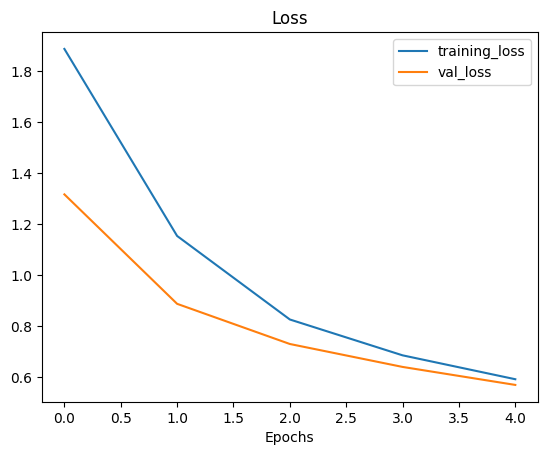

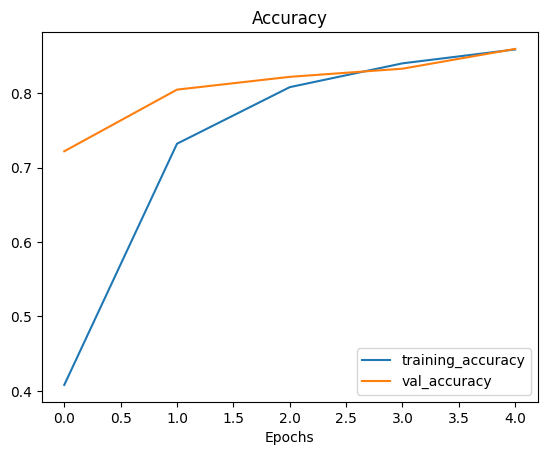

In [16]:
# Loss curves
plot_loss_curves(history_0)

Nice

## Getting a feature vector from a trained model

Demonstrating the Global Average Pooling 2D layer:

1. Have tensors our model goes through "base_model" of shape (None, 7, 7, 1280)

2. After passing through GlobalAveragePooling2D, it turns into (None, 1280).

Using similar tensor shape of (1, 4, 4, 3) and then pass it to GlobalAverage Pooling2D

In [17]:
# Define input shape
input_shape = (1, 4, 4, 3)

# Create rand tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass random tensor through GlobalAveragePooling2D layer
global_avg_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global avg pooling tensor:\n {global_avg_pooling_tensor}\n")

# Check shape
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooling 2d tensor: {global_avg_pooling_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global avg pooling tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooling 2d tensor: (1, 3)


In [18]:
# Replicating GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2]) # should be same as above

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

GlobalAveragePool2D - makes ouput of base model compatible w/ Dense layer, but also condenses info found by base model into lower dimensions for outer layer

## Transfer Learning Experiments

Trying transfer learning w/ only 1% of data instead of 10% of data. (Same data used throughout all experiments)

1. "model_1" - using feature extraction transfer learning w/ 1% of training data w/ data aug
2. "model_2" - using feature extraction transfer leraning w/ 10% of training data w/ data aug
3. "model_3" - using fine-tuning transfer learning on 10% of training data w/ data aug
4. "model_4" - upgrade transfer learning on 100% of training data w/ data aug

### Getting and preprocessing data for model_1

In [19]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-09-20 03:08:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.250.4.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  21.6MB/s    in 7.7s    

2023-09-20 03:08:30 (16.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# Num of images
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'

In [22]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data aug into the actual model

Previously used ImageDataGenerator which augmented images as they were loaded into model

Now use layers inside:
- "tf.keras.layers.preprocessing()"

https://www.tensorflow.org/tutorials/images/data_augmentation

Benefits include:
- Preprocessing images happens on GPU instead of CPU (way slower than GPU)
- Image data aug only happens during training, so model can be exported and used elsewhere.


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data aug w/ horizontal flipping, rotations, zoom, etc...
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1/255.) # Keep for mdoels like ResNet50V2, but EfficientNetV2 models alr have
], name = "data_augmentation")

### Visualize data augmentation layer (seeing what happens to data)


(-0.5, 591.5, 518.5, -0.5)

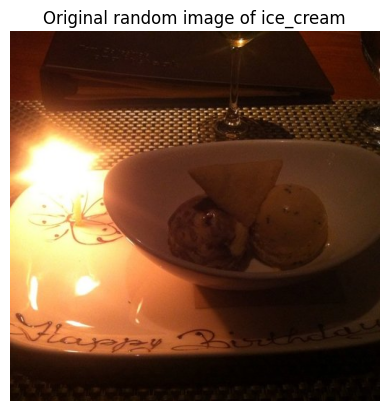

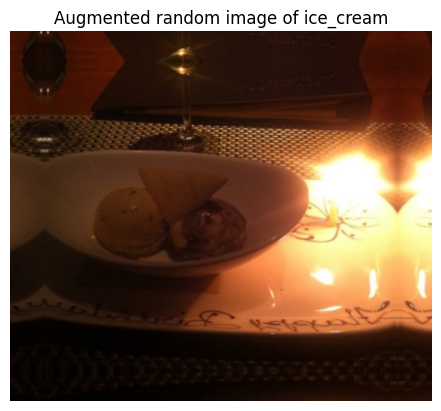

In [45]:
# View rand image and compare to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot rand image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image of {target_class}")
plt.axis(False)

# Plot augmented rand image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image of {target_class}")
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of data w/ data aug

In [50]:
# Setup input shape and base model, freezing base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # keep patterns the same and don't want to change them

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequntial model as a layer
x = data_augmentation(inputs)

# Give base_model inputs aftter augmentation and don't train
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)

# Put dense layer on as output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230920-033245
Epoch 1/5
3/3 [==============================] - 21s 6s/step - loss: 2.3118 - accuracy: 0.1429 - val_loss: 2.1829 - val_accuracy: 0.2304
Epoch 2/5
3/3 [==============================] - 8s 3s/step - loss: 2.0814 - accuracy: 0.3000 - val_loss: 2.0356 - val_accuracy: 0.3408
Epoch 3/5
3/3 [==============================] - 8s 4s/step - loss: 1.9070 - accuracy: 0.4429 - val_loss: 1.9118 - val_accuracy: 0.4360
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.7024 - accuracy: 0.5429 - val_loss: 1.8048 - val_accuracy: 0.5056
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5175 - accuracy: 0.6714 - val_loss: 1.7104 - val_accuracy: 0.5632


In [51]:
model_1.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pooling_layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [52]:
# Evaluate on full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 1.7104 - accuracy: 0.5632


[1.710449457168579, 0.5631999969482422]

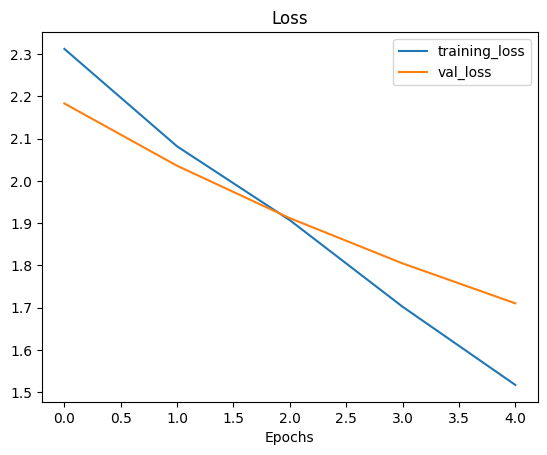

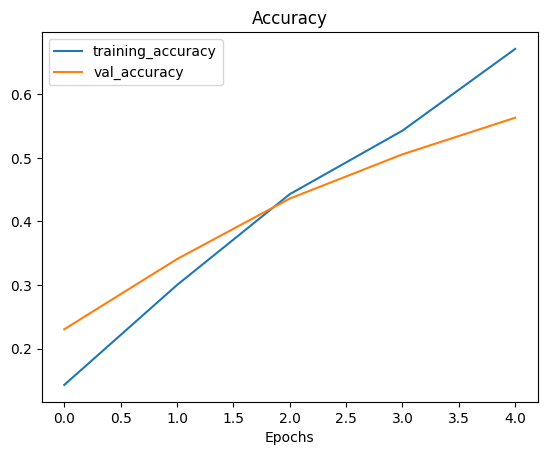

In [53]:
# Looking on loss curves
plot_loss_curves(history_1_percent)

## Model 2